<a href="https://colab.research.google.com/github/jdlin/DFT-PLA/blob/master/TSMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install yfinance
!pip install Backtesting
!pip install talib-binary

In [2]:
import yfinance as yf
import pandas as pd

def get_historical_data(ticker):
  d = yf.Ticker(ticker)
  df = d.history(period="max")
  df.columns = df.columns.str.lower()
  df.columns = pd.Series(df.columns).str.capitalize().values
  return df.dropna()

df = get_historical_data('2330.TW')
df

,Open,High,Low,Close,Volume,Dividends,Stock splits
Date,,,,,,,
2000-01-04,36.507061,36.507061,35.891778,36.507061,200662336736,0.0,0.0
2000-01-05,36.507062,37.327374,36.096808,37.327374,402466805912,0.0,0.0
2000-01-06,37.122344,37.327373,36.507061,36.507061,197545715802,0.0,0.0
2000-01-07,35.276489,35.891772,34.866235,35.481518,235270344752,0.0,0.0
2000-01-10,36.507064,36.917122,35.891782,36.712093,276171685539,0.0,0.0
...,...,...,...,...,...,...,...
2021-07-13,600.000000,608.000000,599.000000,607.000000,52540315,0.0,0.0
2021-07-14,613.000000,615.000000,608.000000,613.000000,38418875,0.0,0.0
2021-07-15,613.000000,614.000000,608.000000,614.000000,22012834,0.0,0.0


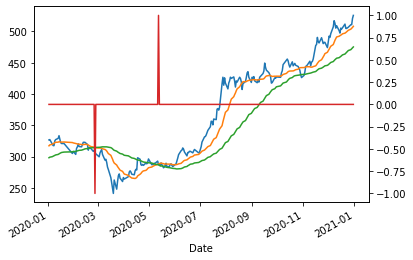

In [4]:
import talib

# compute simple moving average using talib
sma1 = talib.SMA(df.Close, timeperiod=20)
sma2 = talib.SMA(df.Close, timeperiod=60)

# compute buy and sell signals (golden cross and death cross)
signal_long = (sma1 > sma2) & (sma1.shift() < sma2.shift())
signal_short = (sma1 < sma2) & (sma1.shift() > sma2.shift())

# combine long and short signals
signal = signal_long.copy()
signal[signal_short] = -1

df.Close['2020'].plot()
sma1['2020'].plot()
sma2['2020'].plot()
signal['2020'].astype(int).plot(secondary_y=True)

In [10]:
from backtesting import Backtest, Strategy

class Strategy(Strategy):
    
    n1 = 20
    n2 = 60
    
    def init(self):
        super().init()
        
        # Precompute the two moving averages
        close = pd.Series(self.data.Close)
        sma1 = talib.SMA(close, timeperiod=self.n1)
        sma2 = talib.SMA(close, timeperiod=self.n2)

        # Precompute signal
        signal_long = (sma1 > sma2) & (sma1.shift() < sma2.shift())
        signal_short = (sma1 < sma2) & (sma1.shift() > sma2.shift())

        # combine signal
        signal = signal_long
        signal[signal_short] = -1
        
        # plot sma
        self.I(lambda x: sma1, 'sma1')
        self.I(lambda x: sma2, 'sma2')

        # set signal to trade
        self.signal = self.I(lambda x: signal, 'signal')

    def next(self):
        super().next()

        entry_size = self.signal[-1]

        if entry_size > 0:
            self.buy()
        elif entry_size < 0:
          for trade in self.trades:
              trade.close()

bt = Backtest(df, Strategy)
result1 = bt.run()
bt.plot()

# 台積電如何買？用 Python 研發投資策略

In [8]:
result2 = bt.optimize(n1=range(5, 200, 10),
            n2=range(5, 200, 10))
result2._strategy

/usr/local/lib/python3.7/dist-packages/backtesting/backtesting.py:1472: UserWarning: Searching for best of 400 configurations.
  output = _optimize_grid()


<Strategy Strategy(n1=125,n2=5)>

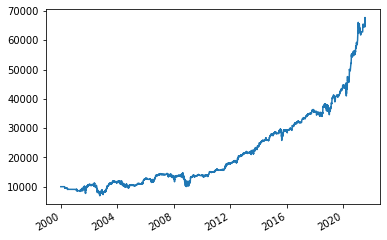

In [9]:
((result1._equity_curve.Equity + 
result2._equity_curve.Equity)/2).plot()

# GOOG backtesting

In [ ]:
!pip install backtesting

In [ ]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

from backtesting.test import SMA, GOOG


class SmaCross(Strategy):
    def init(self):
        price = self.data.Close
        self.ma1 = self.I(SMA, price, 10)
        self.ma2 = self.I(SMA, price, 20)

    def next(self):
        if crossover(self.ma1, self.ma2):
            self.buy()
        elif crossover(self.ma2, self.ma1):
            self.sell()


bt = Backtest(GOOG, SmaCross, commission=.002,
              exclusive_orders=True)
stats = bt.run()
bt.plot()